'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 728f36de-da51-431f-95b5-4f2321e9ab99)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].
Batches: 100%|██████████| 205/205 [00:01<00:00, 111.05it/s]


Loading data from SkyRocket Data_GenAI - Queries.csv...
Loaded 6539 queries.
Generating embeddings (this may take a moment)...


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: b9ee1f14-9cab-42f7-9516-bacd79302f64)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].
Batches: 100%|██████████| 205/205 [00:01<00:00, 132.70it/s]


Running K-Means Clustering...
Running HDBSCAN Clustering...
Extracting insights...
Running t-SNE for visualization...
Visualization saved to skyrocket_insights/tsne_visualization.png
------------------------------
Analysis Complete! check the 'skyrocket_insights' folder.
1. kmeans_topic_insights.csv -> Use this for '10 most frequent topics'
2. hdbscan_emerging_trends.csv -> Use this for 'Emerging topics or escalation trends'
3. tsne_visualization.png -> Use this for your report visualization


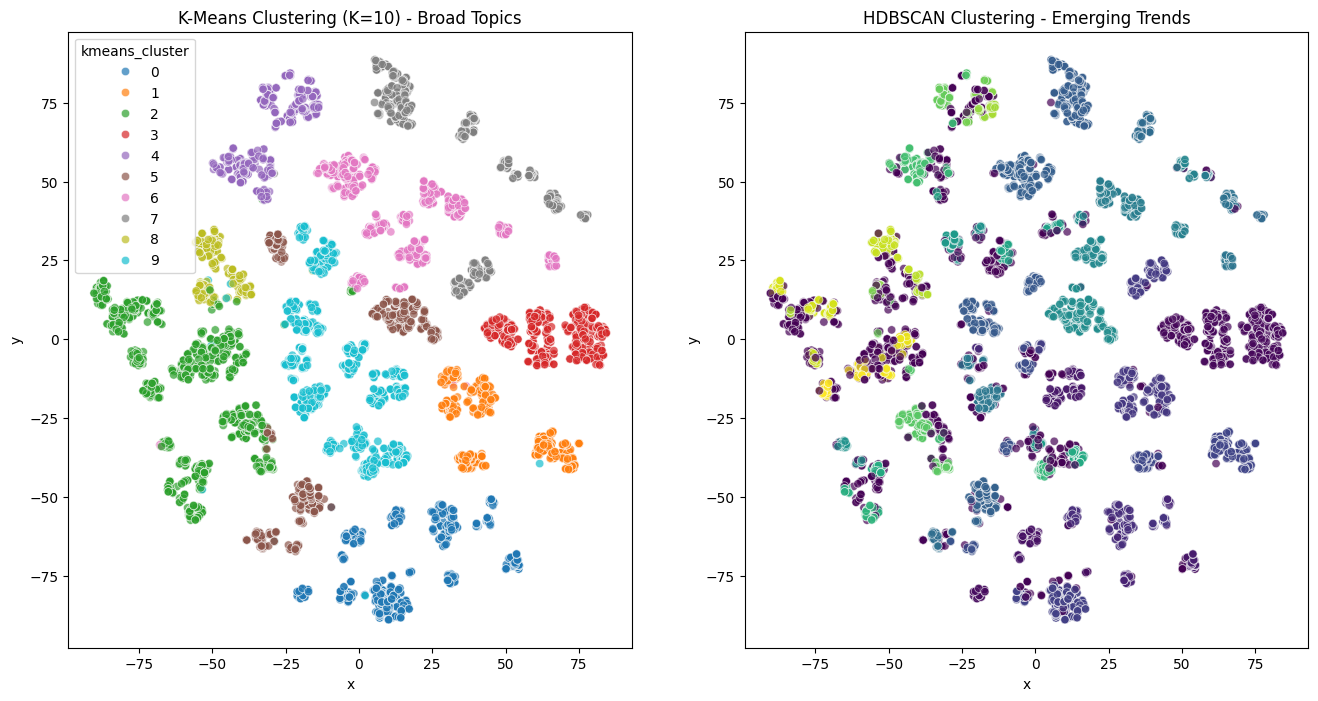

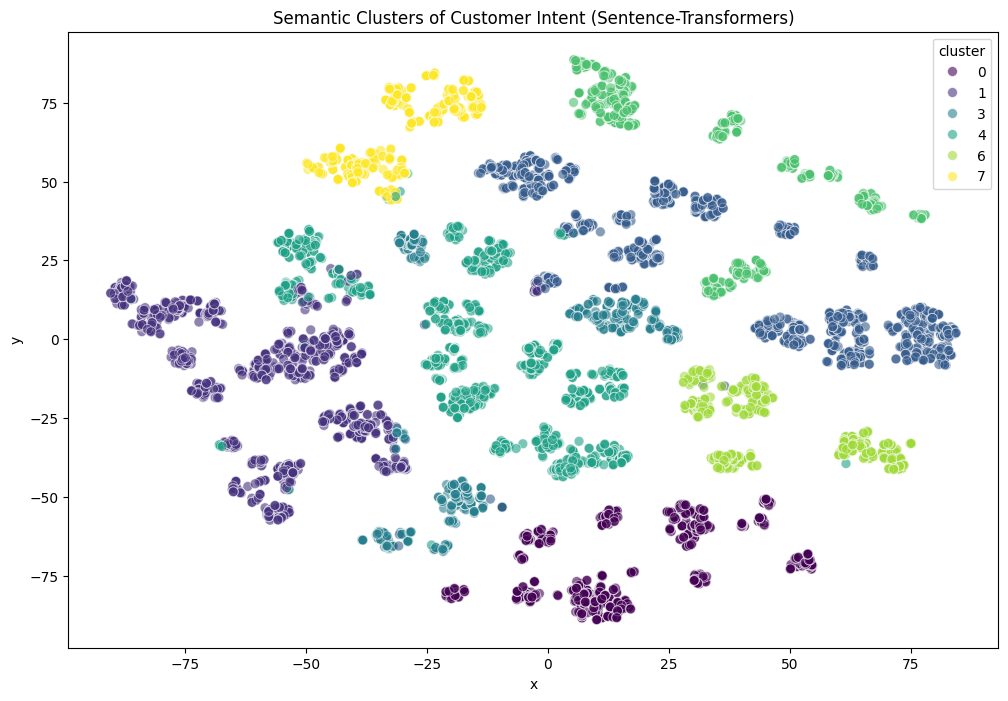

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
df = pd.read_csv('data/SkyRocket Data_GenAI - Queries.csv')

# 2. Vectorization (The "Semantic" Part)
# distinct from TF-IDF, this understands that "broken" and "damaged" are similar.
model = SentenceTransformer('model')
embeddings = model.encode(df['Queries'].astype(str).tolist(), show_progress_bar=True)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import hdbscan
import os

# Configuration
INPUT_FILE = 'SkyRocket Data_GenAI - Queries.csv' 
EMBEDDING_MODEL = 'model'
NUM_TOPICS_KMEANS = 10 
OUTPUT_DIR = 'skyrocket_insights'


os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_and_preprocess(filepath):
    """Loads data and performs basic cleaning."""
    print(f"Loading data from {filepath}...")
    df = pd.read_csv(filepath)
    
    # Basic cleaning
    df['cleaned_queries'] = df['Queries'].astype(str).str.lower().str.strip()
    print(f"Loaded {len(df)} queries.")
    return df

def generate_embeddings(texts):
    """Generates semantic embeddings using SentenceTransformer."""
    print("Generating embeddings (this may take a moment)...")
    model = SentenceTransformer(EMBEDDING_MODEL)
    embeddings = model.encode(texts.tolist(), show_progress_bar=True)
    return embeddings

def perform_clustering(df, embeddings):
    """Performs K-Means and HDBSCAN clustering."""
    print("Running K-Means Clustering...")
    kmeans = KMeans(n_clusters=NUM_TOPICS_KMEANS, random_state=42, n_init=10)
    df['kmeans_cluster'] = kmeans.fit_predict(embeddings)
    
    print("Running HDBSCAN Clustering...")
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
    df['hdbscan_cluster'] = clusterer.fit_predict(embeddings)
    
    return df

def extract_insights(df, cluster_col):
    """Extracts top n-grams and sentiment for each cluster."""
    insights = []
    
    # Group by cluster
    for cluster_id in sorted(df[cluster_col].unique()):
        cluster_df = df[df[cluster_col] == cluster_id]
        
        # Skip noise in HDBSCAN (labeled as -1)
        if cluster_col == 'hdbscan_cluster' and cluster_id == -1:
            continue
            
        # 1. Calculate Average Sentiment
        avg_sentiment = cluster_df['cleaned_queries'].apply(lambda x: TextBlob(x).sentiment.polarity).mean()
        
        # 2. Extract Top Keywords (Bi-grams for better context)
        try:
            vectorizer = CountVectorizer(stop_words='english', ngram_range=(2, 3), max_features=5)
            X = vectorizer.fit_transform(cluster_df['cleaned_queries'])
            top_keywords = ", ".join(vectorizer.get_feature_names_out())
        except ValueError:
            top_keywords = "Not enough data"
            
        # 3. Sample Queries
        samples = cluster_df['Queries'].sample(min(3, len(cluster_df))).tolist()
        
        insights.append({
            'Cluster_ID': cluster_id,
            'Size': len(cluster_df),
            'Avg_Sentiment': round(avg_sentiment, 3),
            'Top_Keywords': top_keywords,
            'Sample_Queries': str(samples)
        })
        
    return pd.DataFrame(insights)

def visualize_clusters(embeddings, df):
    """Reduces dimensions using t-SNE and plots the results."""
    print("Running t-SNE for visualization...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
    vis_dims = tsne.fit_transform(embeddings)
    
    df['x'] = vis_dims[:, 0]
    df['y'] = vis_dims[:, 1]
    
    # Plot K-Means (General Structure)
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x='x', y='y', hue='kmeans_cluster', palette='tab10', data=df, legend='full', alpha=0.7)
    plt.title(f'K-Means Clustering (K={NUM_TOPICS_KMEANS}) - Broad Topics')
    
    # Plot HDBSCAN (Emerging Trends & Outliers)
    plt.subplot(1, 2, 2)
    # Filter out noise (-1) for better color scaling, or plot noise in grey
    sns.scatterplot(x='x', y='y', hue='hdbscan_cluster', palette='viridis', data=df, legend=False, alpha=0.7)
    plt.title('HDBSCAN Clustering - Emerging Trends')
    
    plt.savefig(f'{OUTPUT_DIR}/tsne_visualization.png')
    print(f"Visualization saved to {OUTPUT_DIR}/tsne_visualization.png")

def main():
    df = load_and_preprocess(INPUT_FILE)
    embeddings = generate_embeddings(df['cleaned_queries'])
    df = perform_clustering(df, embeddings)
    print("Extracting insights...")
    kmeans_insights = extract_insights(df, 'kmeans_cluster')
    hdbscan_insights = extract_insights(df, 'hdbscan_cluster')
    visualize_clusters(embeddings, df)
    df.to_csv(f'{OUTPUT_DIR}/full_data_with_clusters.csv', index=False)
    kmeans_insights.sort_values('Size', ascending=False).to_csv(f'{OUTPUT_DIR}/kmeans_topic_insights.csv', index=False)
    hdbscan_insights.sort_values('Size', ascending=False).to_csv(f'{OUTPUT_DIR}/hdbscan_emerging_trends.csv', index=False)
    
    print("-" * 30)
    print(f"Analysis Complete! check the '{OUTPUT_DIR}' folder.")
    print("1. kmeans_topic_insights.csv -> Use this for '10 most frequent topics'")
    print("2. hdbscan_emerging_trends.csv -> Use this for 'Emerging topics or escalation trends'")
    print("3. tsne_visualization.png -> Use this for your report visualization")

if __name__ == "__main__":
    main()
    num_clusters = 8
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    df['cluster'] = kmeans.fit_predict(embeddings)

    # Dimensionality Reduction (For Visualization)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_results = tsne.fit_transform(embeddings)

    df['x'] = tsne_results[:, 0]
    df['y'] = tsne_results[:, 1]

    # Visualization
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=df, x='x', y='y', hue='cluster', palette='viridis', alpha=0.6, s=50
    )
    plt.title('Semantic Clusters of Customer Intent (Sentence-Transformers)')
    plt.savefig('semantic_clusters.png')

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Load the data with clusters
df_clusters = pd.read_csv('skyrocket_insights/full_data_with_clusters.csv')


df_clusters['is_escalation'] = (df_clusters['kmeans_cluster'] == 9).astype(int)

# Preprocessing: TF-IDF
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=1000)
tfidf_matrix = tfidf.fit_transform(df_clusters['Queries'].astype(str))

# Calculate the mean TF-IDF for the Escalation cluster
escalation_indices = df_clusters[df_clusters['is_escalation'] == 1].index
non_escalation_indices = df_clusters[df_clusters['is_escalation'] == 0].index

mean_tfidf_escalation = np.asarray(tfidf_matrix[escalation_indices].mean(axis=0)).ravel()
mean_tfidf_non_escalation = np.asarray(tfidf_matrix[non_escalation_indices].mean(axis=0)).ravel()

# Find words with high TF-IDF in escalation cluster but lower in others
# (Score = Mean TF-IDF in Escalation / (Mean TF-IDF in Non-Escalation + small constant))
diff_score = mean_tfidf_escalation / (mean_tfidf_non_escalation + 0.001)

feature_names = tfidf.get_feature_names_out()
sorted_indices = diff_score.argsort()[::-1]

# Top 20 potential escalation keywords/phrases
top_keywords = []
for i in sorted_indices[:25]:
    top_keywords.append({
        "Keyword/Phrase": feature_names[i],
        "Escalation TF-IDF": mean_tfidf_escalation[i],
        "Ratio": diff_score[i]
    })

top_keywords_df = pd.DataFrame(top_keywords)
print(top_keywords_df)

top_keywords_df.to_csv('extracted_escalation_keywords.csv', index=False)

        Keyword/Phrase  Escalation TF-IDF      Ratio
0                agent           0.058694  58.694077
1               review           0.057117  57.116948
2            complaint           0.056013  56.013032
3         leave review           0.045204  45.204005
4                leave           0.045204  45.204005
5                 file           0.043610  43.609971
6             feedback           0.039645  39.645189
7                 talk           0.036739  36.739267
8               submit           0.036318  36.318405
9       file complaint           0.034859  34.858764
10     submit feedback           0.034065  34.065229
11               speak           0.025627  25.627109
12            business           0.024023  24.023225
13               claim           0.020104  20.103884
14           subscribe           0.019989  19.988944
15       contact agent           0.018783  18.783005
16  complaint business           0.018606  18.605650
17          talk agent           0.017925  17.

In [ ]:
# STEP 2

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('data/SkyRocket Data_GenAI - GenAI_responses.csv')
extracted_escalation_keywords_df = pd.read_csv('skyrocket_insights/extracted_escalation_keywords.csv')


# Escalation Detection
escalation_keywords = extracted_escalation_keywords_df["Keyword/Phrase"].to_list()
def detect_escalation(text):
    text = str(text).lower()
    return any(kw in text for kw in escalation_keywords)

df['is_escalated'] = df['response'].apply(detect_escalation)
df['is_contained'] = ~df['is_escalated']

# Placeholder check
def get_placeholders(text):
    return set(re.findall(r'\{\{.*?\}\}', str(text))) # Find all patterns like {{...}} in Query and Response

df['query_placeholders'] = df['Query'].apply(get_placeholders)
df['response_placeholders'] = df['response'].apply(get_placeholders)
df

,flags,Query,category,Sub Category,response,is_escalated,is_contained,query_placeholders,response_placeholders
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...,False,True,{{{Order Number}}},{{{Order Number}}}
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...,False,True,{{{Order Number}}},{{{Order Number}}}
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...,True,False,{{{Order Number}}},"{{{Online Company Portal Info}}, {{Online Orde..."
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...,True,False,{{{Order Number}}},"{{{Online Company Portal Info}}, {{Online Orde..."
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...,True,False,{{{Order Number}}},"{{{Online Company Portal Info}}, {{Online Orde..."
...,...,...,...,...,...,...,...,...,...
465,BILQ,how to see if there is anything wrong with my ...,REFUND,track_refund,I see what you mean your concern about verifyi...,False,True,{},"{{{Website URL}}, {{Customer Support Phone Num..."
466,BLQZ,I'm waiting for a reimbjrsement of {{Currency ...,REFUND,track_refund,I certainly recognize the importance of your a...,True,False,"{{{Refund Amount}}, {{Currency Symbol}}}","{{{Refund Amount}}, {{Currency Symbol}}}"
467,BILMPQ,could i know if there are any news on the refund,REFUND,track_refund,Of course! I understand your curiosity and des...,False,True,{},{}
468,BLW,I expect a goddamn restitution of {{Currency S...,REFUND,track_refund,"I'm on the same page, the importance of your e...",True,False,"{{{Refund Amount}}, {{Currency Symbol}}}","{{{Refund Amount}}, {{Currency Symbol}}}"


In [ ]:
# Faithfulness Score: Do the response placeholders cover the query placeholders?
def check_faithfulness(row):
    if not row['query_placeholders']:
        return 1.0
    matches = row['query_placeholders'].intersection(row['response_placeholders'])
    return len(matches) / len(row['query_placeholders'])

df['faithfulness_score'] = df.apply(check_faithfulness, axis=1)

# Response Quality Score (Scale 1-5)
def calculate_quality(row):
    score = 3 # Base score
    if row['faithfulness_score'] == 1.0: score += 1
    if re.search(r'\d\.', row['response']): score += 1
    if row['is_escalated'] and row['category'] in ['ORDER', 'INVOICE', 'DELIVERY']: score -= 1
    if len(str(row['response'])) < 100: score -= 1
    return max(1, min(5, score))

df['quality_score'] = df.apply(calculate_quality, axis=1)
df

,flags,Query,category,Sub Category,response,is_escalated,is_contained,query_placeholders,response_placeholders,faithfulness_score,quality_score
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...,False,True,{{{Order Number}}},{{{Order Number}}},1.0,4
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...,False,True,{{{Order Number}}},{{{Order Number}}},1.0,4
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...,True,False,{{{Order Number}}},"{{{Online Company Portal Info}}, {{Online Orde...",1.0,4
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...,True,False,{{{Order Number}}},"{{{Online Company Portal Info}}, {{Online Orde...",1.0,4
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...,True,False,{{{Order Number}}},"{{{Online Company Portal Info}}, {{Online Orde...",1.0,4
...,...,...,...,...,...,...,...,...,...,...,...
465,BILQ,how to see if there is anything wrong with my ...,REFUND,track_refund,I see what you mean your concern about verifyi...,False,True,{},"{{{Website URL}}, {{Customer Support Phone Num...",1.0,4
466,BLQZ,I'm waiting for a reimbjrsement of {{Currency ...,REFUND,track_refund,I certainly recognize the importance of your a...,True,False,"{{{Refund Amount}}, {{Currency Symbol}}}","{{{Refund Amount}}, {{Currency Symbol}}}",1.0,4
467,BILMPQ,could i know if there are any news on the refund,REFUND,track_refund,Of course! I understand your curiosity and des...,False,True,{},{},1.0,4
468,BLW,I expect a goddamn restitution of {{Currency S...,REFUND,track_refund,"I'm on the same page, the importance of your e...",True,False,"{{{Refund Amount}}, {{Currency Symbol}}}","{{{Refund Amount}}, {{Currency Symbol}}}",1.0,4


In [11]:
df['quality_score'].unique()

array([4, 3, 5])

In [12]:
# Hallucination Detection (Placeholder Mismatch)
# If response has placeholders NOT related to category
def detect_hallucination(row):
    placeholders = row['response_placeholders']
    cat = row['category']
    # Example logic: If CATEGORY is ORDER but has {{Refund Amount}} without {{Order Number}}
    if cat == 'ORDER' and '{{Refund Amount}}' in str(placeholders) and '{{Order Number}}' not in str(placeholders):
        return True
    return False

df['is_hallucination'] = df.apply(detect_hallucination, axis=1)
df

,flags,Query,category,Sub Category,response,is_escalated,is_contained,query_placeholders,response_placeholders,faithfulness_score,quality_score,is_hallucination
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...,False,True,{{{Order Number}}},{{{Order Number}}},1.0,4,False
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...,False,True,{{{Order Number}}},{{{Order Number}}},1.0,4,False
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...,True,False,{{{Order Number}}},"{{{Online Company Portal Info}}, {{Online Orde...",1.0,4,False
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...,True,False,{{{Order Number}}},"{{{Online Company Portal Info}}, {{Online Orde...",1.0,4,False
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...,True,False,{{{Order Number}}},"{{{Online Company Portal Info}}, {{Online Orde...",1.0,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...
465,BILQ,how to see if there is anything wrong with my ...,REFUND,track_refund,I see what you mean your concern about verifyi...,False,True,{},"{{{Website URL}}, {{Customer Support Phone Num...",1.0,4,False
466,BLQZ,I'm waiting for a reimbjrsement of {{Currency ...,REFUND,track_refund,I certainly recognize the importance of your a...,True,False,"{{{Refund Amount}}, {{Currency Symbol}}}","{{{Refund Amount}}, {{Currency Symbol}}}",1.0,4,False
467,BILMPQ,could i know if there are any news on the refund,REFUND,track_refund,Of course! I understand your curiosity and des...,False,True,{},{},1.0,4,False
468,BLW,I expect a goddamn restitution of {{Currency S...,REFUND,track_refund,"I'm on the same page, the importance of your e...",True,False,"{{{Refund Amount}}, {{Currency Symbol}}}","{{{Refund Amount}}, {{Currency Symbol}}}",1.0,4,False


In [13]:
df['is_hallucination'].unique()

array([False])

/tmp/ipykernel_449316/1458781440.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Contained', 'Escalated'], y=[rates[True], rates[False]], palette='viridis')
/tmp/ipykernel_449316/1458781440.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_quality.index, y=cat_quality.values, palette='magma')
/tmp/ipykernel_449316/1458781440.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='category', order=df['category'].value_counts().index, palette='coolwarm')


{'Total Responses': 470, 'Containment Rate (%)': np.float64(61.91489361702127), 'Escalation Rate (%)': np.float64(38.08510638297872), 'Average Quality Score': np.float64(4.1063829787234045), 'Hallucination Rate (%)': np.float64(0.0)}


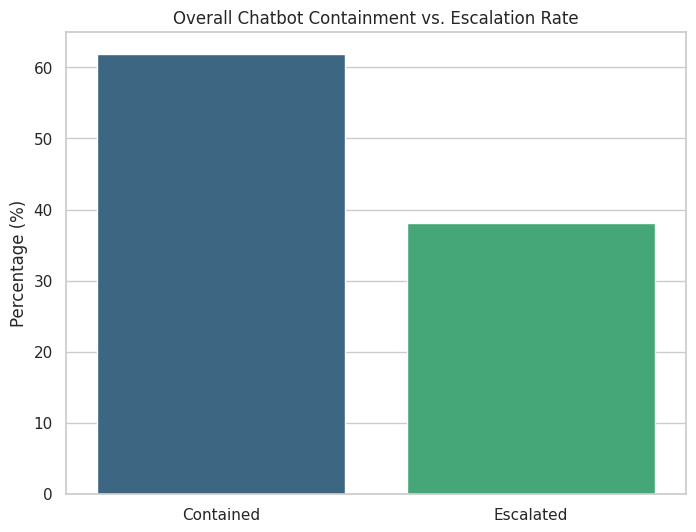

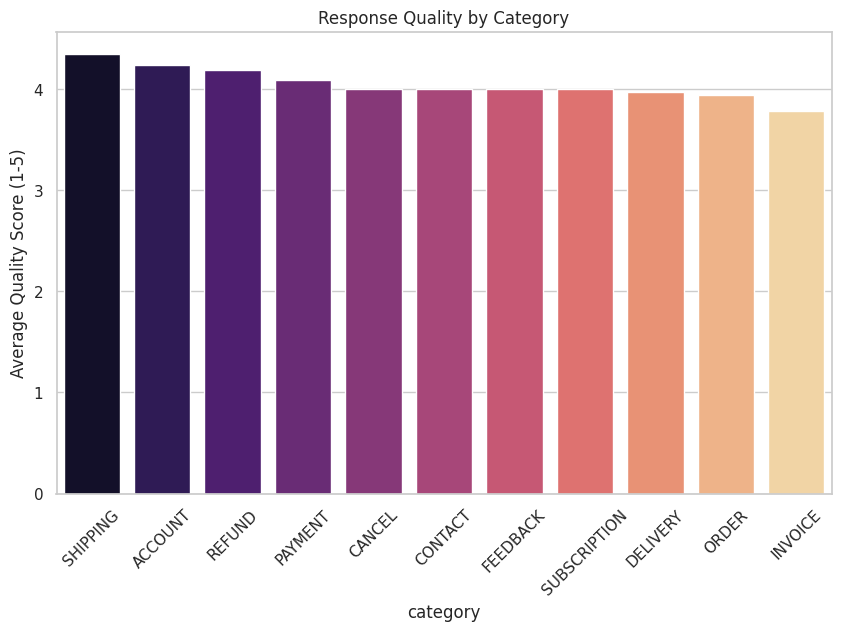

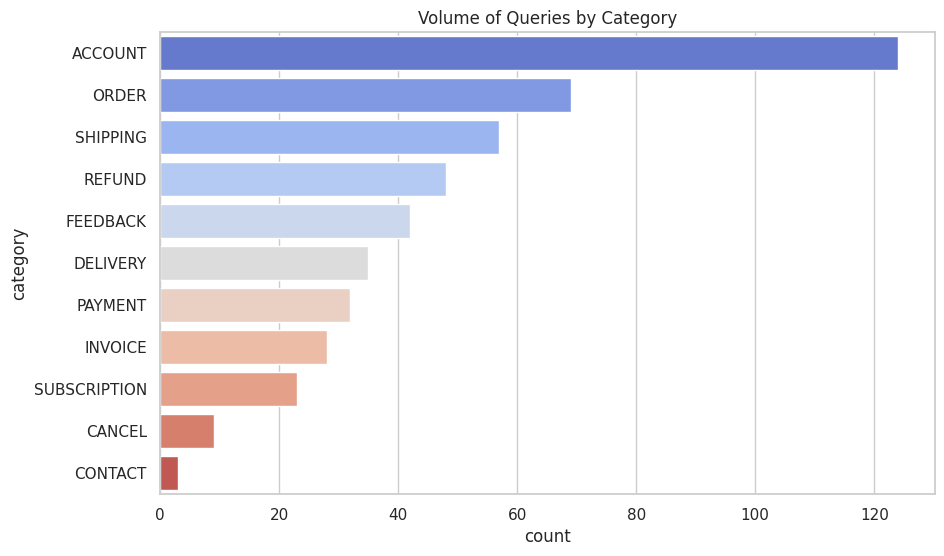

In [ ]:
# Set style
sns.set(style="whitegrid")

# Plot 1: Containment vs Escalation Rate
rates = df['is_contained'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 6))
sns.barplot(x=['Contained', 'Escalated'], y=[rates[True], rates[False]], palette='viridis')
plt.ylabel('Percentage (%)')
plt.title('Overall Chatbot Containment vs. Escalation Rate')
plt.savefig('containment_escalation_rate.png')

# Plot 2: Average Quality Score by Category
plt.figure(figsize=(10, 6))
cat_quality = df.groupby('category')['quality_score'].mean().sort_values(ascending=False)
sns.barplot(x=cat_quality.index, y=cat_quality.values, palette='magma')
plt.ylabel('Average Quality Score (1-5)')
plt.title('Response Quality by Category')
plt.xticks(rotation=45)
plt.savefig('quality_by_category.png')

# Plot 3: Topic-level trends (Volume)
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='category', order=df['category'].value_counts().index, palette='coolwarm')
plt.title('Volume of Queries by Category')
plt.savefig('topic_volume_trends.png')

# Export enriched data
df.to_csv('enriched_genai_responses.csv', index=False)

# Summary statistics for report
summary = {
    'Total Responses': len(df),
    'Containment Rate (%)': rates[True],
    'Escalation Rate (%)': rates[False],
    'Average Quality Score': df['quality_score'].mean(),
    'Hallucination Rate (%)': (df['is_hallucination'].sum() / len(df)) * 100
}
print(summary)

In [ ]:
import pandas as pd

# Load the GenAI responses
df_res = pd.read_csv('data/SkyRocket Data_GenAI - GenAI_responses.csv')

# 1. Inspect the 'flags' column to see what values it contains
print("Unique Flags:", df_res['flags'].unique())

# 2. Check for cases where the Query intent seems to mismatch the Response intent. Since we don't have a model here, let's look for keyword mismatches. Example: Query has 'cancel' but Response doesn't, or vice-versa.
def check_mismatch(row):
    q = str(row['Query']).lower()
    r = str(row['response']).lower()
    cat = str(row['category']).lower()
    
    # If category is ORDER but response talks about REFUND without mentioning order
    if 'order' in cat and 'refund' in r and 'order' not in r:
        return True
    # If category is REFUND but response talks about ORDER only
    if 'refund' in cat and 'order' in r and 'refund' not in r:
        return True
    return False

df_res['mismatch'] = df_res.apply(check_mismatch, axis=1)
mismatched_samples = df_res[df_res['mismatch']]

print(f"Number of keyword mismatches found: {len(mismatched_samples)}")
if not mismatched_samples.empty:
    print(mismatched_samples[['Query', 'category', 'response']].head())

# 3. Look for "H" in flags if it exists
hallucinated_by_flag = df_res[df_res['flags'].str.contains('H', na=False)]
print(f"Number of rows with 'H' in flags: {len(hallucinated_by_flag)}")
if not hallucinated_by_flag.empty:
    print(hallucinated_by_flag[['flags', 'Query', 'response']].head())

# 4. Check 'Bias' (B)
bias_by_flag = df_res[df_res['flags'].str.contains('B', na=False)]
print(f"Number of rows with 'B' in flags: {len(bias_by_flag)}")

Unique Flags: ['B' 'BQZ' 'BLQZ' 'BL' 'BCELN' 'BI' 'BCLN' 'BLQ' 'BQ' 'BLM' 'BILQ' 'BIL'
 'BLMQZ' 'BELN' 'BLMQ' 'BELNQ' 'BK' 'BILMQZ' 'BCL' 'BLP' 'BCIL' 'BCLQZ'
 'BLZ' 'BLW' 'BILP' 'BILMQ' 'BEL' 'BCEL' 'BILZ' 'BZ' 'BLMW' 'BE' 'BELPQZ'
 'BCEQ' 'BCILPW' 'BKLZ' 'BILW' 'BKL' 'BILM' 'BCILPZ' 'BIQ' 'BELQ' 'BILQZ'
 'BILQW' 'BILMP' 'BILS' 'BILMW' 'BLS' 'BCLW' 'BMQ' 'BILMZ' 'BKLQ' 'BCIP'
 'BKLM' 'BCILPQ' 'BILMQW' 'BCEILP' 'BELQZ' 'BEQ' 'BLPW' 'BEMQ' 'BCELMV'
 'BIQZ' 'BCQZ' 'BCILQ' 'BCEILMP' 'BQWZ' 'BELMQ' 'BLMZ' 'BCILM' 'BLNW'
 'BLMN' 'BCLQ' 'BELP' 'BILPQW' 'BEQZ' 'BLWZ' 'BCILPQW' 'BCIPQZ' 'BLQWZ'
 'BIQW' 'BCLQW' 'BQW' 'BILMPQ']
Number of keyword mismatches found: 3
                                                 Query category  \
269  I want assistance obtaining a reimbursement of...   REFUND   
276  could you help me to request a restitution of ...   REFUND   
465  how to see if there is anything wrong with my ...   REFUND   

                                              response  
269  I pic

Unique characters in Flags: ['B', 'C', 'E', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'S', 'V', 'W', 'Z']
Flag Counts: {'B': np.int64(470), 'C': np.int64(51), 'E': np.int64(42), 'I': np.int64(115), 'K': np.int64(45), 'L': np.int64(425), 'M': np.int64(81), 'N': np.int64(10), 'P': np.int64(22), 'Q': np.int64(161), 'S': np.int64(2), 'V': np.int64(1), 'W': np.int64(24), 'Z': np.int64(87)}
Number of 'I' flags (Inaccuracy?): 115
Hallucinations by Heuristic: 1


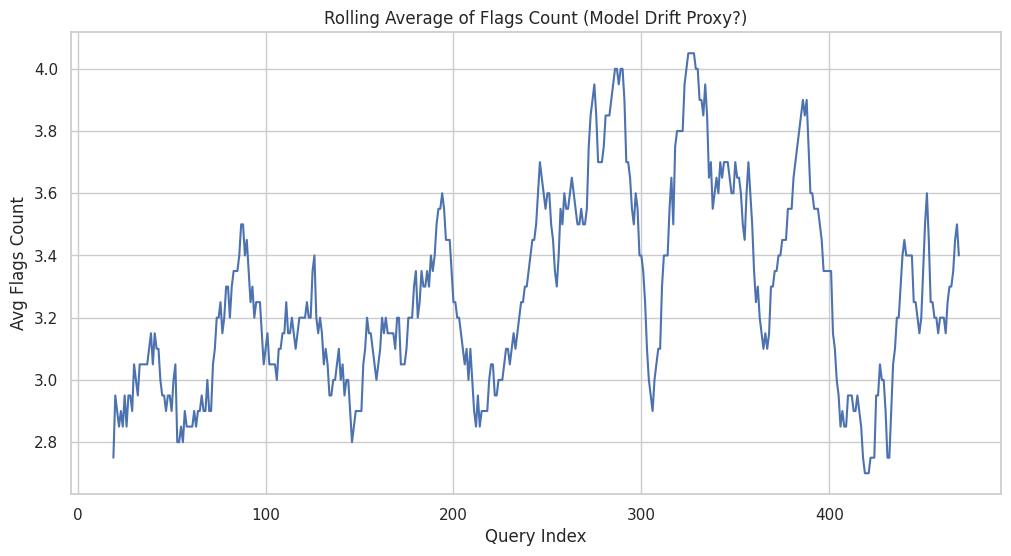

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_res = pd.read_csv('data/SkyRocket Data_GenAI - GenAI_responses.csv')

all_flags = "".join(df_res['flags'].astype(str).unique())
unique_chars = sorted(set(all_flags))
print("Unique characters in Flags:", unique_chars)

# Count occurrences of each flag
flag_counts = {char: df_res['flags'].str.contains(char, na=False).sum() for char in unique_chars}
print("Flag Counts:", flag_counts)

# Identify potential "Hallucinations" (H) - though count was 0, double check
# Maybe 'I' is Inaccuracy?
# Let's inspect rows with 'I'
i_flags = df_res[df_res['flags'].str.contains('I', na=False)]
print(f"Number of 'I' flags (Inaccuracy?): {len(i_flags)}")

# Let's check for "Hallucinations" by comparing Query and Response keywords
# If Query has 'cancel' but Response has 'password', it's a hallucination of intent.
from collections import Counter

def evaluate_hallucination_intent(row):
    q = str(row['Query']).lower()
    r = str(row['response']).lower()
    cat = str(row['category']).lower()
    
    # Check for category-response mismatch
    if 'order' in cat and ('password' in r or 'registration' in r): return True
    if 'refund' in cat and ('password' in r or 'delivery' in r and 'refund' not in r): return True
    if 'account' in cat and ('order' in r and 'account' not in r): return True
    return False

df_res['hallucination_heuristic'] = df_res.apply(evaluate_hallucination_intent, axis=1)
print("Hallucinations by Heuristic:", df_res['hallucination_heuristic'].sum())

# Inspect the logic for "Model Drift"
# Let's plot flag density over the index
plt.figure(figsize=(12, 6))
# Calculate number of flags per row
df_res['num_flags'] = df_res['flags'].apply(len)
sns.lineplot(x=df_res.index, y=df_res['num_flags'].rolling(window=20).mean())
plt.title("Rolling Average of Flags Count (Model Drift Proxy?)")
plt.xlabel("Query Index")
plt.ylabel("Avg Flags Count")
plt.savefig('model_drift_proxy.png')

In [18]:
# Inspecting 'I' flagged rows
print("Samples of 'I' flagged responses:")
print(df_res[df_res['flags'].str.contains('I', na=False)][['Query', 'category', 'response']].head(5))

# Check for category vs response mismatch more deeply
# E.g. Query asks to change address, Category says ORDER, Response talks about Order cancellation.
# Let's count how many responses contain words from other categories
def check_category_conflict(row):
    r = str(row['response']).lower()
    cat = str(row['category']).lower()
    
    conflicts = {
        'ORDER': ['refund', 'password', 'invoice'],
        'REFUND': ['password', 'shipping address', 'invoice'],
        'ACCOUNT': ['cancel order', 'invoice', 'delivery'],
        'INVOICE': ['refund', 'cancel order', 'shipping address']
    }
    
    if cat in conflicts:
        for bad_word in conflicts[cat]:
            if bad_word in r:
                return True
    return False

df_res['category_conflict'] = df_res.apply(check_category_conflict, axis=1)
print(f"Category Conflicts: {df_res['category_conflict'].sum()}")

# Sample of conflict
if df_res['category_conflict'].sum() > 0:
    print(df_res[df_res['category_conflict']][['Query', 'category', 'response']].head(2))

Samples of 'I' flagged responses:
                                                Query category  \
5      can you help me cancel order {{Order Number}}?    ORDER   
13               how to modify order {{Order Number}}    ORDER   
16              how do I edit order {{Order Number}}?    ORDER   
18  how can I swap a product of order {{Order Numb...    ORDER   
33  can ya help me switching several products of o...    ORDER   

                                             response  
5   Of course, I'm here to assist you in canceling...  
13  I can tell that you would like to modify order...  
16  We appreciate your inquiry about editing order...  
18  We understand that you're looking for assistan...  
33  We appreciate you contacting us for assistance...  
Category Conflicts: 0


In [19]:
# Check for "Hardcoded" values (Hallucinations of specific data)
import re

def check_hardcoded_hallucination(row):
    q = str(row['Query'])
    r = str(row['response'])
    
    # Find numbers in response that are not in query
    r_nums = set(re.findall(r'\d+', r))
    q_nums = set(re.findall(r'\d+', q))
    
    # Ignore small numbers (1, 2, 3) used for steps
    diff = r_nums - q_nums - {'1', '2', '3', '4', '5', '6', '7', '8', '9', '0'}
    
    if diff:
        return True, diff
    return False, None

df_res['hardcoded_hallucination'] = df_res.apply(lambda x: check_hardcoded_hallucination(x)[0], axis=1)
print(f"Hardcoded Hallucinations (new numbers): {df_res['hardcoded_hallucination'].sum()}")

# Inspect flags V, S, N
print("\nSpecial Flags Inspection:")
for flag in ['V', 'S', 'N']:
    sample = df_res[df_res['flags'].str.contains(flag, na=False)]
    if not sample.empty:
        print(f"Flag '{flag}' sample (first 2):")
        print(sample[['flags', 'Query', 'response']].head(2))
        print("-" * 20)

Hardcoded Hallucinations (new numbers): 3

Special Flags Inspection:
Flag 'V' sample (first 2):
      flags                                              Query  \
279  BCELMV  I have paid {{Currency Symbol}}{{Refund Amount...   

                                              response  
279  I've got that you have made a payment of ${{Re...  
--------------------
Flag 'S' sample (first 2):
    flags                              Query  \
192  BILS  do you ship to {{Delivery City}}?   
198   BLS     shipments to {{Delivery City}}   

                                              response  
192  Unquestionably! We offer shipping to {{Deliver...  
198  Certainly! Let's explore the shipment options ...  
--------------------
Flag 'N' sample (first 2):
   flags                                              Query  \
4  BCELN  I cannot afford this order, cancel purchase {{...   
6   BCLN  I can no longer afford order {{Order Number}},...   

                                            response  


In [27]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   flags                    470 non-null    object
 1   Query                    470 non-null    object
 2   category                 470 non-null    object
 3   Sub Category             470 non-null    object
 4   response                 470 non-null    object
 5   hallucination_heuristic  470 non-null    bool  
 6   num_flags                470 non-null    int64 
 7   category_conflict        470 non-null    bool  
 8   hardcoded_hallucination  470 non-null    bool  
dtypes: bool(3), int64(1), object(5)
memory usage: 23.5+ KB


In [26]:
df_res['hallucination_heuristic'].value_counts()

hallucination_heuristic
False    469
True       1
Name: count, dtype: int64